In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as ptchs
from matplotlib import gridspec
import matplotlib.text as mtext
import scipy.integrate
import scipy.optimize

class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, r'\textbf{' + orig_handle + '}', usetex=True, **self.text_props)
        handlebox.add_artist(title)
        return title

In [2]:
class MinorSymLogLocator(ticker.Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh, nints=10):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically. nints gives the number of
        intervals that will be bounded by the minor ticks.
        """
        self.linthresh = linthresh
        self.nintervals = nints

    def __call__(self):
        # Return the locations of the ticks
        majorlocs = self.axis.get_majorticklocs()

        if len(majorlocs) == 1:
            return self.raise_if_exceeds(np.array([]))

        # add temporary major tick locs at either end of the current range
        # to fill in minor tick gaps
        dmlower = majorlocs[1] - majorlocs[0]    # major tick difference at lower end
        dmupper = majorlocs[-1] - majorlocs[-2]  # major tick difference at upper end

        # add temporary major tick location at the lower end
        if majorlocs[0] != 0. and ((majorlocs[0] != self.linthresh and dmlower > self.linthresh) or (dmlower == self.linthresh and majorlocs[0] < 0)):
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]*10.)
        else:
            majorlocs = np.insert(majorlocs, 0, majorlocs[0]-self.linthresh)

        # add temporary major tick location at the upper end
        if majorlocs[-1] != 0. and ((np.abs(majorlocs[-1]) != self.linthresh and dmupper > self.linthresh) or (dmupper == self.linthresh and majorlocs[-1] > 0)):
            majorlocs = np.append(majorlocs, majorlocs[-1]*10.)
        else:
            majorlocs = np.append(majorlocs, majorlocs[-1]+self.linthresh)

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = self.nintervals
            else:
                ndivs = self.nintervals - 1.

            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                          '%s type.' % type(self))

In [3]:
def convert_to_type(df, col, type):
    df[col] =  df[col].apply(lambda s: type(s))

def normalize_df(df, cols, norm):
    for col in cols:
        df[col] = df[col].div(df[norm])

def map_distr_name(distr):
    s = distr.split("-")
    n = distr
    if "constant" in distr:
        n = f"{s[0]}({s[1]})"
    elif "normal" in distr:
        n = f"{s[0]}({s[1]}, {s[2]})"
    return n.title()

def human_readable(val):
    if int(val/1e9) > 0:
        return f"{int(val/1e9)}B"
    elif int(val/1e6) > 0:
        return f"{int(val/1e6)}M"
    elif int(val/1e3) > 0:
        return f"{int(val/1e3)}K"
    else:
        return str(int(val))
        
def convert_unit(x):
    """
    Get factor to convert to seconds
    """
    if x == "s":
        return 1
    elif x == "ms":
        return 1e3
    elif x == "us":
        return 1e6
    elif x == "ns":
        return 1e9

def unit_to_unit_factor(u1, u2):
    f1 = convert_unit(u1)
    f2 = convert_unit(u2)
    return f2/f1

def mae(pred, observ):
    return np.sum(np.abs(pred-observ))/len(pred)

def r2(pred, observ):
    return 1- (np.sum(np.power(pred-observ, 2)) / np.sum(np.power(observ - np.mean(observ), 2)))

# Find Bin

In [477]:
filename = "../microbenchmarks/das6/binarysearch_gpu.json" 
with open(filename, "r") as f:
    jdata = json.load(f)
bsbm_df = pd.DataFrame.from_dict(jdata["benchmarks"]).astype({"real_time" : float})

convert_to_type(bsbm_df, "real_time", np.float64)
bsbm_df["func_name"] = bsbm_df["name"].apply(lambda s: s.split("/")[0][3:])    
bsbm_df["time_factor"] = bsbm_df["time_unit"].apply(convert_unit)
del bsbm_df["family_index"], bsbm_df["per_family_instance_index"]
bsbm_df["time_factor"] = bsbm_df["time_unit"].apply(convert_unit)

bsbm_df.head(10)

,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,cpu_time,time_unit,blocksize,bulksize,nbins,numblocks,val,func_name,time_factor
0,BM_BinarySearchConstantGPU/8/32/32/0/manual_ti...,BM_BinarySearchConstantGPU/8/32/32/0/manual_time,aggregate,1000.0,1,mean,time,3,7474.645414,15.202032,ms,32.0,32.0,1.0,1.0,0.0,BinarySearchConstantGPU,1000.0
1,BM_BinarySearchConstantGPU/8/32/32/0/manual_ti...,BM_BinarySearchConstantGPU/8/32/32/0/manual_time,aggregate,1000.0,1,median,time,3,7364.640079,15.102185,ms,32.0,32.0,1.0,1.0,0.0,BinarySearchConstantGPU,1000.0
2,BM_BinarySearchConstantGPU/8/32/32/0/manual_ti...,BM_BinarySearchConstantGPU/8/32/32/0/manual_time,aggregate,0.0,1,stddev,time,3,377.173698,0.378744,ms,0.0,0.0,0.0,0.0,0.0,BinarySearchConstantGPU,1000.0
3,BM_BinarySearchConstantGPU/8/32/32/0/manual_ti...,BM_BinarySearchConstantGPU/8/32/32/0/manual_time,aggregate,0.0,1,cv,percentage,3,0.050460,0.024914,ms,0.0,0.0,0.0,0.0,NaN,BinarySearchConstantGPU,1000.0
4,BM_BinarySearchConstantGPU/16/32/32/0/manual_t...,BM_BinarySearchConstantGPU/16/32/32/0/manual_time,aggregate,1000.0,1,mean,time,3,7198.570753,14.970426,ms,32.0,32.0,2.0,1.0,0.0,BinarySearchConstantGPU,1000.0
5,BM_BinarySearchConstantGPU/16/32/32/0/manual_t...,BM_BinarySearchConstantGPU/16/32/32/0/manual_time,aggregate,1000.0,1,median,time,3,7141.280091,14.898030,ms,32.0,32.0,2.0,1.0,0.0,BinarySearchConstantGPU,1000.0
6,BM_BinarySearchConstantGPU/16/32/32/0/manual_t...,BM_BinarySearchConstantGPU/16/32/32/0/manual_time,aggregate,0.0,1,stddev,time,3,145.985801,0.158437,ms,0.0,0.0,0.0,0.0,0.0,BinarySearchConstantGPU,1000.0
7,BM_BinarySearchConstantGPU/16/32/32/0/manual_t...,BM_BinarySearchConstantGPU/16/32/32/0/manual_time,aggregate,0.0,1,cv,percentage,3,0.020280,0.010583,ms,0.0,0.0,0.0,0.0,NaN,BinarySearchConstantGPU,1000.0
8,BM_BinarySearchConstantGPU/32/32/32/0/manual_t...,BM_BinarySearchConstantGPU/32/32/32/0/manual_time,aggregate,1000.0,1,mean,time,3,7262.965411,15.054385,ms,32.0,32.0,4.0,1.0,0.0,BinarySearchConstantGPU,1000.0
9,BM_BinarySearchConstantGPU/32/32/32/0/manual_t...,BM_BinarySearchConstantGPU/32/32/32/0/manual_time,aggregate,1000.0,1,median,time,3,7347.712072,15.137209,ms,32.0,32.0,4.0,1.0,0.0,BinarySearchConstantGPU,1000.0


In [478]:
n_param = len(bsbm_df["name"].values[0].split("/")) - 1
for i in range(n_param):
    if i == n_param - 1:
        bsbm_df[f"param_{i}"] = bsbm_df["name"].apply(lambda s: s.split("/")[i+1].split("_")[0] if i+1 < len(s.split("_/")) else None)
    else:
        bsbm_df[f"param_{i}"] = bsbm_df["name"].apply(lambda s: s.split("/")[i+1] if i+1 < len(s.split("/")) else None)

convert_to_type(bsbm_df, "nbins", np.int64)
convert_to_type(bsbm_df, "param_1", np.int64)
convert_to_type(bsbm_df, "param_2", np.int64)
convert_to_type(bsbm_df, "blocksize", np.int64)

bsbm_mean = bsbm_df.loc[bsbm_df["name"].str.contains("mean")].reset_index()
bsbm_std = bsbm_df.loc[bsbm_df["name"].str.contains("stddev")].reset_index()
# convert_to_type(
bsbm_mean

,index,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,...,nbins,numblocks,val,func_name,time_factor,param_0,param_1,param_2,param_3,param_4
0,0,BM_BinarySearchConstantGPU/8/32/32/0/manual_ti...,BM_BinarySearchConstantGPU/8/32/32/0/manual_time,aggregate,1000.0,1,mean,time,3,7474.645414,...,1,1.0,0.0,BinarySearchConstantGPU,1000.0,8,32,32,0,None
1,4,BM_BinarySearchConstantGPU/16/32/32/0/manual_t...,BM_BinarySearchConstantGPU/16/32/32/0/manual_time,aggregate,1000.0,1,mean,time,3,7198.570753,...,2,1.0,0.0,BinarySearchConstantGPU,1000.0,16,32,32,0,None
2,8,BM_BinarySearchConstantGPU/32/32/32/0/manual_t...,BM_BinarySearchConstantGPU/32/32/32/0/manual_time,aggregate,1000.0,1,mean,time,3,7262.965411,...,4,1.0,0.0,BinarySearchConstantGPU,1000.0,32,32,32,0,None
3,12,BM_BinarySearchConstantGPU/64/32/32/0/manual_t...,BM_BinarySearchConstantGPU/64/32/32/0/manual_time,aggregate,1000.0,1,mean,time,3,7203.264085,...,8,1.0,0.0,BinarySearchConstantGPU,1000.0,64,32,32,0,None
4,16,BM_BinarySearchConstantGPU/128/32/32/0/manual_...,BM_BinarySearchConstantGPU/128/32/32/0/manual_...,aggregate,1000.0,1,mean,time,3,7298.389414,...,16,1.0,0.0,BinarySearchConstantGPU,1000.0,128,32,32,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,34924,BM_BinarySearchRandomGPU/16777216/262144/1024/...,BM_BinarySearchRandomGPU/16777216/262144/1024/...,aggregate,1000.0,1,mean,time,3,6271.114827,...,2097152,256.0,NaN,BinarySearchRandomGPU,1000.0,16777216,262144,1024,manual_time_mean,None
8732,34928,BM_BinarySearchRandomGPU/33554432/262144/1024/...,BM_BinarySearchRandomGPU/33554432/262144/1024/...,aggregate,1000.0,1,mean,time,3,5822.890737,...,4194304,256.0,NaN,BinarySearchRandomGPU,1000.0,33554432,262144,1024,manual_time_mean,None
8733,34932,BM_BinarySearchRandomGPU/67108864/262144/1024/...,BM_BinarySearchRandomGPU/67108864/262144/1024/...,aggregate,1000.0,1,mean,time,3,5762.357389,...,8388608,256.0,NaN,BinarySearchRandomGPU,1000.0,67108864,262144,1024,manual_time_mean,None
8734,34936,BM_BinarySearchRandomGPU/134217728/262144/1024...,BM_BinarySearchRandomGPU/134217728/262144/1024...,aggregate,1000.0,1,mean,time,3,5776.010725,...,16777216,256.0,NaN,BinarySearchRandomGPU,1000.0,134217728,262144,1024,manual_time_mean,None


<function matplotlib.pyplot.show(close=None, block=None)>

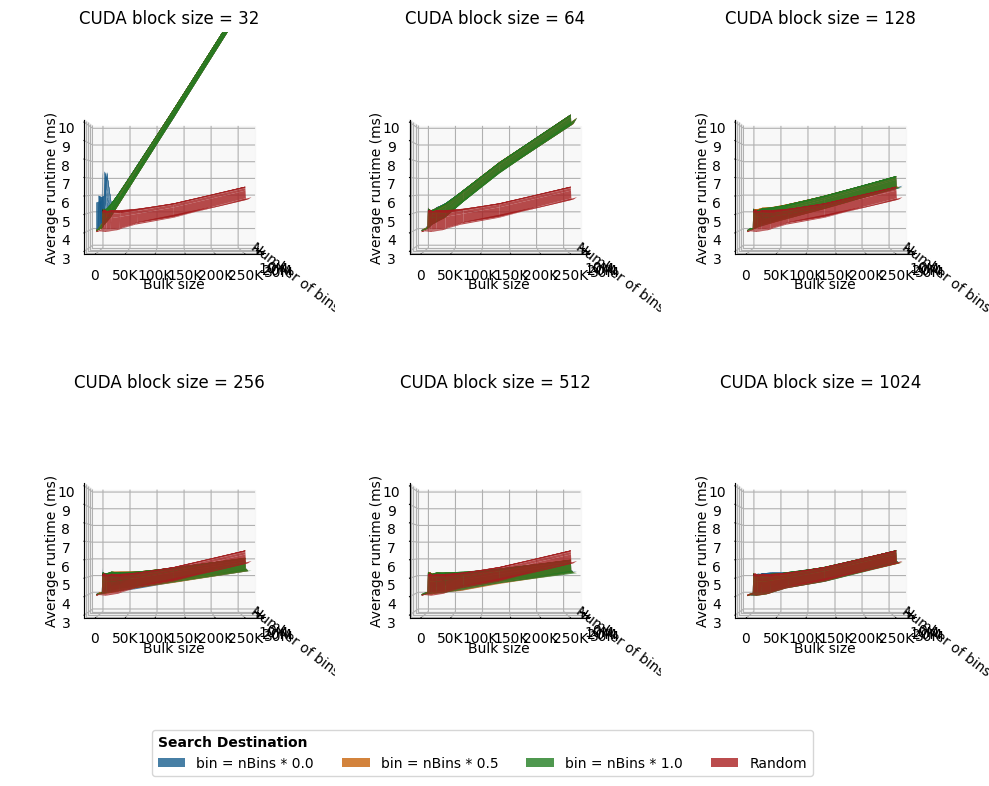

In [490]:
# figname = "../../images/gpu_binsearchconstant_mb_3d.pdf"
selected_size = 33554432
selected_bulksize = 32768
selected_blocksize = 1024
selected_val = 0
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]

# fig = plt.figure(figsize=(8, 3))


fig, axs = plt.subplots(nrows=2, ncols=3, subplot_kw={"projection": "3d"}, figsize=(10, 10))
for bi, bs in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchConstantGPU"]["blocksize"].unique()):
    ax = axs[int(bi/3), bi%3]
    for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchConstantGPU"]["param_3"].unique()):
        ax.set_title(f"CUDA block size = {bs}")
        arg = ((bsbm_mean["func_name"] == "BinarySearchConstantGPU") 
               & (bsbm_mean["param_3"] == dest) 
               & (bsbm_mean["blocksize"] == bs)
              )
        avg = bsbm_mean.loc[arg]
        std = bsbm_std.loc[arg]
        X = avg["nbins"].unique()
        Y = avg["bulksize"].unique() # bulksize
        Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
        ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                         # yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                        alpha=0.8,
                        label=f"bin = nBins * {int(dest)/4.}")


    arg = ((bsbm_mean["func_name"] == "BinarySearchRandomGPU")
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    X = avg["nbins"].unique()
    Y = avg["bulksize"].unique() # bulksize
    Z = avg["real_time"] * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep
    ax.plot_surface(*np.meshgrid(X,Y), np.reshape(Z, (len(Y), len(X))),
                 # yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                    alpha=0.8,
                    label=f"Random",
                )

    ax.set_xlabel("Number of bins")
    # ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_ylabel("Bulk size")
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
    ax.set_zlabel(f"Average runtime ({unit})")
    # ax.set_yscale("log", base=2)
    ax.set_zlim(3, 10)
    ax.zaxis.labelpad=-0.7 # <- change the value here
    ax.view_init(elev=0, azim=0, roll=0)
    ax.set_box_aspect(aspect=None, zoom=0.83)

hndls = ax.get_legend_handles_labels()[0]
lbls = ax.get_legend_handles_labels()[1]

# plt.savefig(figname, format="pdf", bbox_inches='tight')
fig.legend(hndls, lbls, title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.15, .09), ncols=4)
fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=-0.4)
plt.show

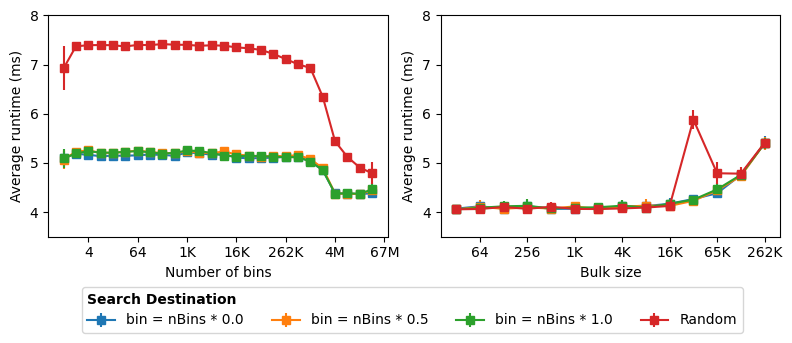

In [503]:
# figname = "../../images/gpu_binsearch_mb.pdf"

selected_size = 33554432
selected_bulksize = 32768*2
selected_blocksize = 256
selected_val = 0
unit = "ms"
rep  = bsbm_mean["repetitions"].values[0]

fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(121)

df = bsbm_mean.loc[arg]
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchConstantGPU"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchConstantGPU") 
           & (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["bulksize"] == selected_bulksize) 
           & (bsbm_mean["blocksize"] == selected_blocksize)
          )
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["nbins"], 
                 avg["real_time"]  * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep,
                 yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                 marker="s",label=f"bin = nBins * {int(dest)/4.}")

selected_func = "BinarySearchRandomGPU"
arg = ((bsbm_mean["func_name"] == selected_func) 
       & (bsbm_mean["bulksize"] == selected_bulksize) 
       & (bsbm_mean["blocksize"] == selected_blocksize)
      )
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["nbins"], 
             avg["real_time"]  * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep,
             yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
             marker="s", label=f"Random"
            )

plt.xlabel("Number of bins")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
plt.ylim([3.5, 8])

#############

ax = plt.subplot(122)
for di, dest in enumerate(bsbm_mean.loc[bsbm_mean["func_name"] == "BinarySearchConstantGPU"]["param_3"].unique()):
    arg = ((bsbm_mean["func_name"] == "BinarySearchConstantGPU")
           &  (bsbm_mean["param_3"] == dest) 
           & (bsbm_mean["nbins"] == selected_size)  
           & (bsbm_mean["blocksize"] == selected_blocksize))
    avg = bsbm_mean.loc[arg]
    std = bsbm_std.loc[arg]
    plt.errorbar(avg["bulksize"], avg["real_time"]  * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep,
                 yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
                 marker="s",
                 # label=f"v = {int(dest)/4.}"
                )
arg = ((bsbm_mean["func_name"] == selected_func)
       & (bsbm_mean["nbins"] == selected_size)  
       & (bsbm_mean["blocksize"] == selected_blocksize))
avg = bsbm_mean.loc[arg]
std = bsbm_std.loc[arg]
plt.errorbar(avg["bulksize"], avg["real_time"]  * unit_to_unit_factor(bsbm_mean["time_unit"].values[0], unit) / rep,
             yerr=std["real_time"] * unit_to_unit_factor(bsbm_std["time_unit"].values[0], unit) / rep, 
             # label=f"v = {int(dest)/4.}"
                 marker="s",
             
            )

plt.xlabel("Bulk size")
plt.xscale("log", base=2)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{human_readable(int(x))}"))
plt.ylabel(f"Average runtime ({unit})")
# plt.yscale("symlog")
plt.ylim([3.5, 8])

# plt.savefig(figname, format="pdf", bbox_inches='tight')
fig.legend(title="Search Destination",alignment="left", title_fontproperties={'weight':'bold'}, 
           loc='lower left', bbox_to_anchor=(.1, -0.15), ncols=4)
plt.tight_layout()
plt.show();

In [295]:
arg = (bsbm_mean["func_name"] == "BinarySearchConstantGPU") &  (bsbm_mean["param_1"] == dest) & (bsbm_mean["nbins"] == selected_size)  & (bsbm_mean["blocksize"] == selected_blocksize)
avg = bsbm_mean.loc[arg]
avg

,index,name,run_name,run_type,repetitions,threads,aggregate_name,aggregate_unit,iterations,real_time,...,nbins,numblocks,val,func_name,time_factor,param_0,param_1,param_2,param_3,param_4


In [472]:
avg["numblocks"].unique()

array([1.000e+00, 2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01,
       6.400e+01, 1.280e+02, 2.560e+02, 5.120e+02, 1.024e+03])

# Add Bin Content

# Update Stats